## Train a rate network to generate sines at different frequencies in response to a static input.
    - Freeze J weights, plug in random V weights (thal -> cortex), learn U weights (cortex -> thalamus)

In [1]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy
import pickle

In [2]:
# define a simple network composed of recurrent J weights and a single linear readout
class multiSpeedRNN(nn.Module):
    def __init__(self, nneurons_ctx: int = 200, nneurons_thal: int=50, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights and set a few parameters
        J_mat = (1.2 * np.random.randn(nneurons_ctx, nneurons_ctx)/np.sqrt(nneurons_ctx))
        self.J = nn.Parameter(torch.from_numpy(J_mat.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy((np.random.randn(1, nneurons_ctx)/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_ctx,1)/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.U    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_ctx,nneurons_thal)/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.V    = nn.Parameter(torch.from_numpy((np.zeros((nneurons_thal,nneurons_ctx))).astype(np.float32)).to(self.device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.movement_time_range = [0.1,6]
        self.input_on_time_range = [0,0]
        self.output_delay = 0
        self.Loss = []
        self.rates = None
        #self.create_targets_and_inputs()
        self.output = None
        self.inputs = None
        self.batch_size = 2
        self.initialState_ctx = torch.randn((self.J.shape[0], 1), device=device) / np.sqrt(self.J.shape[0])
        self.initialState_thal = torch.zeros((self.V.shape[0], 1), device=device)

    def create_targets_and_inputs(self, frequencies=None, amplitude: int = 1):

        if frequencies is None:
            frequencies = [1, 2]

        # choose a random time for the input to go high (start movement)
        #start_idx = np.random.randint(low=int(self.input_on_time_range[0]/self.dt),high=int(self.input_on_time_range[1]/self.dt))
        start_idx=0

        # index where the output starts
        #movement_start_idx = start_idx + int(self.output_delay / self.dt)
        movement_start_idx=0

        # choose a movement duration for this trial
        move_duration =  np.diff(self.movement_time_range)[0] * np.random.random() + self.movement_time_range[0]

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt) + 1

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-4):
        device = self.device
        batch_size = 2
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState_ctx
            rm1 = self.neural_nonlinearity(xm1)

            xthal = self.initialState_thal
            rthal = self.neural_nonlinearity(xthal)

            for idx in np.arange(0,trial_length):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) + self.V.T @ rthal +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                xthal = self.U.T @ rm1
                rthal = self.neural_nonlinearity(xthal)
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]

        # average loss over time and trials
        loss = ((Targets - position_store)**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_initial_m1(self, trials: int = 2000):
        m1_params = [self.J, self.Wout, self.Win]
        optimizer = torch.optim.Adam(m1_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs()
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

    def fit_withThal(self, trials: int = 2000):

        # connect thal -> cortex
        self.V.data = torch.from_numpy((np.random.randn(self.V.shape[0],self.J.shape[0])/np.sqrt(self.J.shape[0])).astype(np.float32))

        thal_params = [self.U, self.Wout, self.Win]
        optimizer = torch.optim.Adam(thal_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs()
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

    # return inputs, rates, targets, outputs, without any noise
    def returnRates(self, start_idx: int=0,move_duration: float=6.0):

        device = self.device

        # generate our inputs
        frequencies = [1,2]

        # number of conditions
        numConds = len(frequencies)

        # index where the output starts
        #movement_start_idx = start_idx + int(self.output_delay / self.dt)
        movement_start_idx = 0

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # convert to tensor
        Inputs = torch.from_numpy(inputs.astype(np.float32))

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        amplitude=1
        for ii in range(numConds):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        # run the model forward
        numNeurons = self.initialState.shape[0]

        # rates are T x N x C
        rates = np.zeros((trl_l,numNeurons,numConds))

        # output is T x C
        output = np.zeros((trl_l,numConds))

        # set the noise scale
        noise_scale = 1e-4

        # cycle through conditions
        for trl in range(numConds):

            xm1 = self.initialState_ctx
            rm1 = self.neural_nonlinearity(xm1)

            xthal = self.initialState_thal
            rthal = self.neural_nonlinearity(xthal)

            for idx in np.arange(0,trl_l):


                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) + self.V.T @ rthal))

                rm1 = self.neural_nonlinearity(xm1)
                xthal = self.U.T @ rm1
                rthal = self.neural_nonlinearity(xthal)

                rates[idx,:,trl] = rm1.detach().numpy()[:,0]
                output[idx,trl]  = (self.Wout @ rm1).detach().numpy()[0][0]


        return inputs, targets, output, rates


### Train the model with backprop

In [3]:
# initialize and fit the model
model = multiSpeedRNN()
model.fit_initial_m1()

# plug in thalamus, freeze J weights, learn U weights
model.fit_withThal()

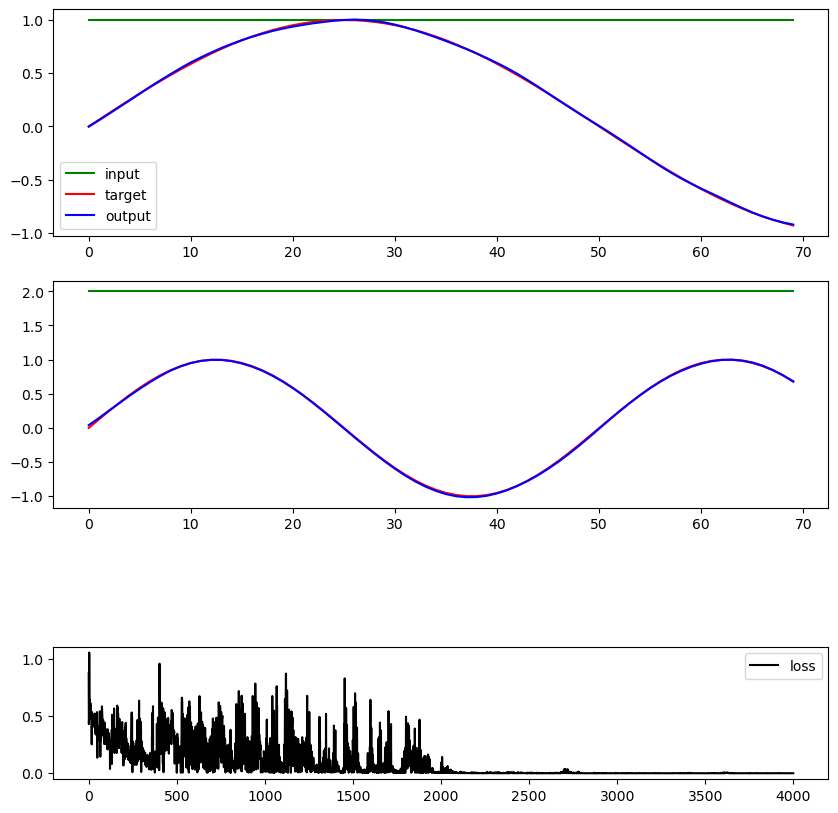

In [4]:
# plot the final output and the loss over training
modelOutput = model.output.detach().numpy()
target = model.Targets
input = model.Inputs
loss = model.Loss
plt.figure(figsize=(10,10))
for ii in range(2):

    plt.subplot(3,1,ii+1);
    plt.plot(input[:,ii],'g',label='input');
    plt.plot(target[:,ii],'r',label = 'target');
    plt.plot(modelOutput[:,ii],'b',label='output');
    if ii == 0:
        plt.legend();

plt.subplot(5,1,5);
plt.plot(loss,'k',label='loss');
plt.legend();


In [5]:
# save the model
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/realisticBG/'

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# set up the path and dictionary
savePath = savePath
state_dict = model.state_dict()
data_dict = {'model_state': state_dict, 'full_model': model}

# save
np.save(savePath + ct + '.npy',data_dict)

In [ ]:
# or load a previously trained network
# path to saved network
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/multiSpeedCycling/'

# file to load
fName = '2023-08-29 13_40_23.npy'

data = np.load(savePath + fName,allow_pickle=True)
data = data.ravel()[0]
model = data['full_model']

In [20]:
# pull out trained weights
W_in  = model.Win.detach().numpy()
J     = model.J.detach().numpy()
W_out = model.Wout.detach().numpy()
U     = model.U.detach().numpy().T
V     = model.V.detach().numpy().T

# pull out initial state for cortex and thalamus
initialState_ctx  = model.initialState_ctx.detach().numpy()
initialState_thal = model.initialState_thal.detach().numpy()

# pull out original output
originalOutput = model.output.detach().numpy()

# pull out some timing-related variables
dt = model.dt
tau = model.tau

# save inputs (stretch out to 500 samples)
Input = np.tile(model.Inputs[0,:][np.newaxis,:],(500,1))

# grab some useful numbers
numThal,numCtx = U.shape

mean (absolute) correlation: 0.05855958


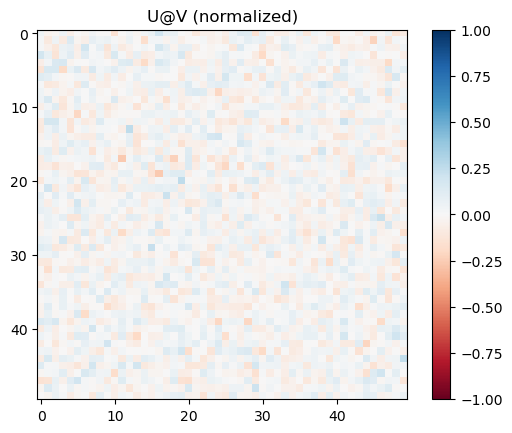

In [14]:
# how well aligned are U and V?
# normalize each
U_norm = U / np.linalg.norm(U,axis=1)[:,np.newaxis]
V_norm = V / np.linalg.norm(V,axis=0)
plt.imshow(U_norm@V_norm,vmin=-1,vmax=1,cmap='RdBu')
plt.title('U@V (normalized)');
plt.colorbar()

# calculate mean (absolute) correlation
print('mean (absolute) correlation: ' + str(np.mean(np.abs(U_norm@V_norm))))

mean (absolute) correlation: 0.060948327


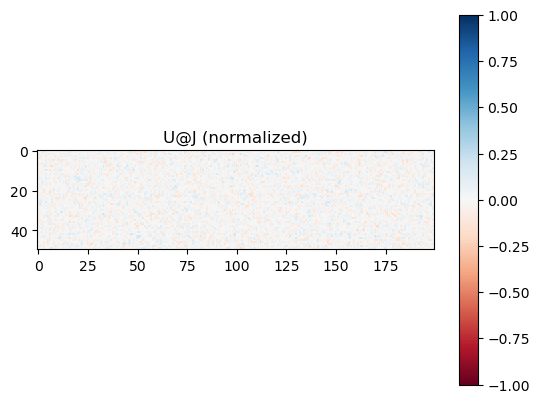

In [15]:
# how well aligned are U and J?
J_norm = J / np.linalg.norm(J,axis=0)

# plot correlation matrix
plt.imshow(U_norm@J_norm,vmin=-1,vmax=1,cmap='RdBu')
plt.title('U@J (normalized)');
plt.colorbar()

# calculate mean (absolute) correlation
print('mean (absolute) correlation: ' + str(np.mean(np.abs(U_norm@J_norm))))

mean (absolute) correlation: 0.055915467


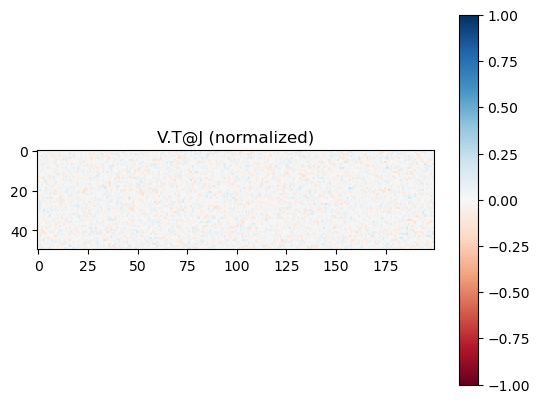

In [16]:
# how well aligned are J and V?

# plot correlation matrix
plt.imshow(V_norm.T @ J_norm, vmin=-1, vmax=1, cmap='RdBu')
plt.title('V.T@J (normalized)');
plt.colorbar()

# calculate mean (absolute) correlation
print('mean (absolute) correlation: ' + str(np.mean(np.abs(V_norm.T @ J_norm))))

In [17]:
# how well aligned are J and W_out?
W_out_norm = W_out / np.linalg.norm(W_out)

# calculate mean (absolute) correlation
print('mean (absolute) correlation: ' + str(np.mean(np.abs(W_out_norm@J_norm))))

mean (absolute) correlation: 0.07027504


### all our weights  (J, U, V, B_out) are all nicely uncorrelated.
    - mean correlation around 0.05

In [21]:
# function that returns rates and network output given a static inhibitory input to thalamus
def returnRates(ipt,bg_b,w_in=W_in,j=J,u=U,v=V,w_out=W_out):

    ## initialize arrays to track rates and output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numUnits_thal,numUnits_ctx = u.shape

    # initialize our matrices
    allRates_ctx    = np.zeros((trlDuration, numConds, numUnits_ctx))
    allRates_thal   = np.zeros((trlDuration, numConds, numUnits_thal))
    allOutputs = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        x_ctx = np.copy(initialState_ctx)
        r_ctx = np.tanh(x_ctx)

        x_thal = np.copy(initialState_thal)
        r_thal = np.tanh(x_thal)

        for ii in range(trlDuration):

            # update ctx state
            x_ctx = x_ctx + dt/tau * (-x_ctx + (j @ r_ctx + (ipt[ii,cc] * w_in) + v @ r_thal))

            # get cortical rates
            r_ctx = np.tanh(x_ctx)

            # get thalamic state
            x_thal = (u @ r_ctx) + bg_b[ii,:,cc]

            # thalamic rates
            r_thal = np.tanh(x_thal)

            # save rates
            allRates_ctx[ii,cc,:]  = r_ctx[:,0]
            allRates_thal[ii,cc,:] = r_thal[:,0]

            # save output
            allOutputs[ii,cc]  = (w_out @ r_ctx)[0][0]

    return allRates_ctx, allRates_thal, allOutputs


### Add a small, random inhibitory vector to thalamus, look at results


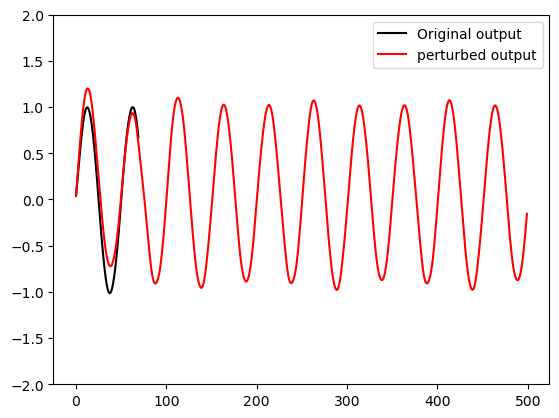

In [22]:
# choose a random inhibitory vector (static over time)

# range of BG input
bgRange = [-0.5,0]
bg_B = np.diff(bgRange) * np.random.random_sample(size=numThal) + bgRange[0]

# repeat input over entire trial
trlDur = Input.shape[0]
bg_B = np.tile(bg_B[np.newaxis,:],(trlDur,1))

# get output
ctxRates, thalRates, out = returnRates(ipt=Input[:,1][:,np.newaxis],bg_b=bg_B[:,:,np.newaxis])

# plot output (and original output)
plt.plot(originalOutput[:,1],'k',label='Original output');
plt.plot(out,'r',label='perturbed output');
plt.legend();
plt.ylim([-2,2]);

### add small, random changes to U

In [77]:
# first, get 500 ms of non-perturbed output

# input from BG (just zeros)
trlDur = Input.shape[0]
bg_B = np.zeros((trlDur,U.shape[0]))

# get output
ctxRates, thalRates, originalOutput = returnRates(ipt=Input[:,1][:,np.newaxis],bg_b=bg_B[:,:,np.newaxis])

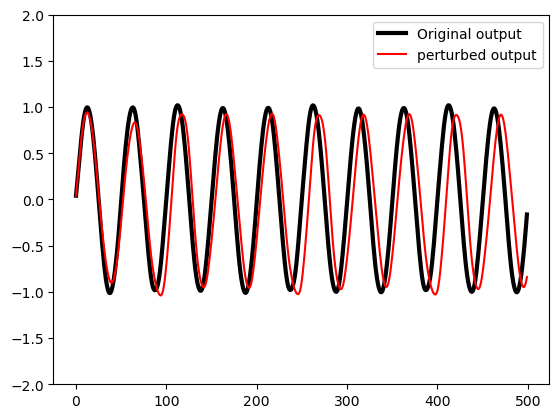

In [96]:
# get a random perturbation to U
uPertMag = 3e-1
uPert = 2 * np.random.random_sample(size=U.shape) -1

# normalize
uPert = uPert / np.linalg.norm(uPert,axis=0)
uPert = uPert * np.tile(uPertMag,(U.shape[0],1))

# get output
ctxRates, thalRates, out = returnRates(ipt=Input[:,1][:,np.newaxis],u=U + uPert,bg_b=bg_B[:,:,np.newaxis])

# plot output (and original output)
plt.plot(originalOutput,'k',label='Original output',lw=3);
plt.plot(out,'r',label='perturbed output');
plt.legend();
plt.ylim([-2,2]);

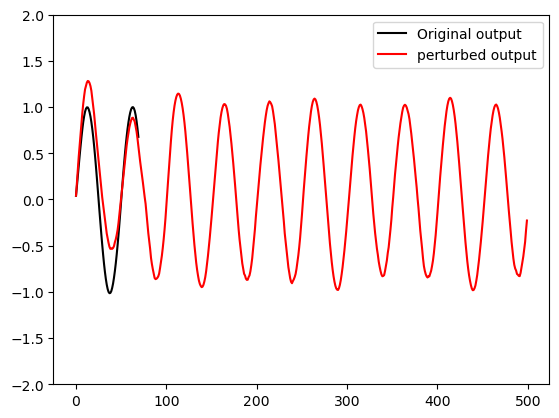

In [23]:
# choose a random inhibitory vector (changes over time)

# trial duration
trlDur = Input.shape[0]

# range of BG input
bgRange = [-1,0]
bg_B = np.diff(bgRange) * np.random.random_sample(size=(trlDur,numThal)) + bgRange[0]


# get output
ctxRates, thalRates, out = returnRates(ipt=Input[:,1][:,np.newaxis],bg_b=bg_B[:,:,np.newaxis])

# plot output (and original output)
plt.plot(originalOutput[:,1],'k',label='Original output');
plt.plot(out,'r',label='perturbed output');
plt.legend();
plt.ylim([-2,2]);

In [36]:
# use backprop to learn bg input that changes the output
class bgLearningRNN(nn.Module):
    def __init__(self, nneurons_ctx: int = 200, nneurons_thal: int=50, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights (from the previously trained model)
        self.J = nn.Parameter(torch.from_numpy(J.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy(W_out.astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy(W_in.astype(np.float32)).to(device))
        self.U    = nn.Parameter(torch.from_numpy((U.T).astype(np.float32)).to(device))
        self.V    = nn.Parameter(torch.from_numpy((V.T).astype(np.float32)).to(self.device))
        self.B    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_thal, 1)/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.Loss = []
        self.output = None
        self.inputs = None
        self.batch_size = 2
        self.initialState_ctx = torch.from_numpy(initialState_ctx).to(device)
        self.initialState_thal = torch.from_numpy(initialState_thal).to(device)

    def create_targets_and_inputs(self, frequencies=None, amplitudes=None):

        if frequencies is None:
            frequencies = [1, 2]
        if amplitudes is None:
            amplitudes = [1,1]

        # time when input goes high
        start_idx=0

        # index where the output starts
        movement_start_idx=0

        # choose a movement duration for this trial
        move_duration =  Input.shape[0]*self.dt

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        inputs[:,1] = inputs[:,0]

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitudes[ii] * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-5):
        device = self.device
        batch_size = 2
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState_ctx
            rm1 = self.neural_nonlinearity(xm1)

            xthal = self.initialState_thal
            rthal = self.neural_nonlinearity(xthal)

            for idx in np.arange(0,trial_length):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) + self.V.T @ rthal +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                xthal = (self.U.T @ rm1) + self.B
                rthal = self.neural_nonlinearity(xthal)
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]

        # average loss over time and trials
        loss = ((Targets - position_store)**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_B(self, trials: int = 100, amplitudes = None,frequencies = None):

        if amplitudes is None:
            amplitudes = [1,1]
        if frequencies is None:
            frequencies = [1,2]

        B_params = [self.B]
        optimizer = torch.optim.Adam(B_params, lr=1e-3)

        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs(amplitudes=amplitudes,frequencies=frequencies)
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()


In [43]:
# fit new model
model2 = bgLearningRNN()
model2.fit_B(trials = 1000,amplitudes=[1,1],frequencies=[1.1,1.1]);


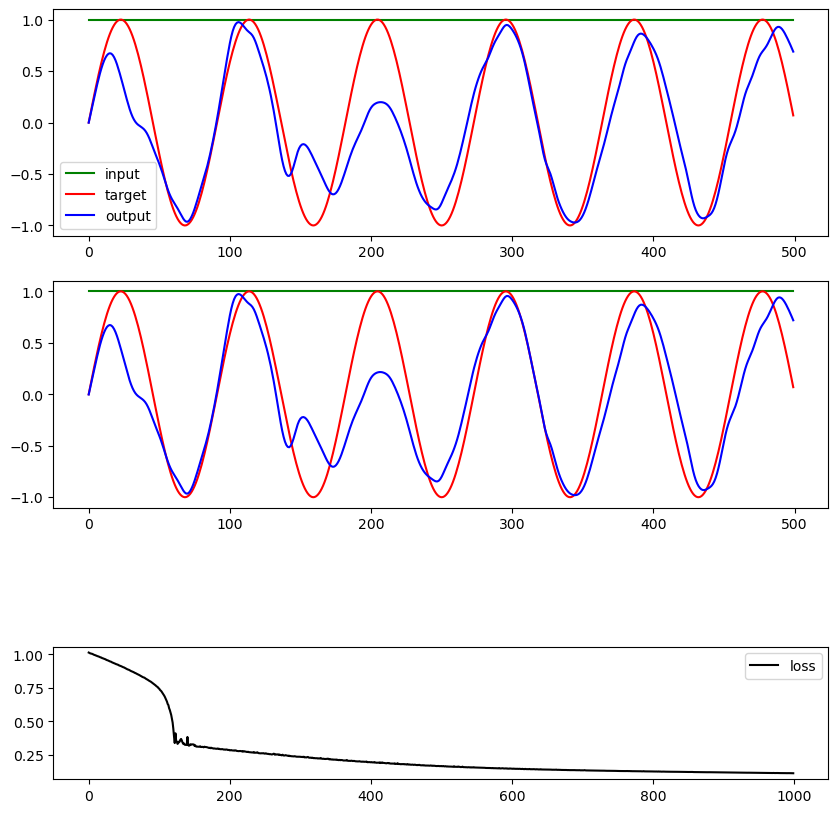

In [44]:
# plot the final output and the loss over training
modelOutput = model2.output.detach().numpy()
target = model2.Targets
input = model2.Inputs
loss = model2.Loss
plt.figure(figsize=(10,10))
for ii in range(2):

    plt.subplot(3,1,ii+1);
    plt.plot(input[:,ii],'g',label='input');
    plt.plot(target[:,ii],'r',label = 'target');
    plt.plot(modelOutput[:,ii],'b',label='output');
    if ii == 0:
        plt.legend();

plt.subplot(5,1,5);
plt.plot(loss,'k',label='loss');
plt.legend();


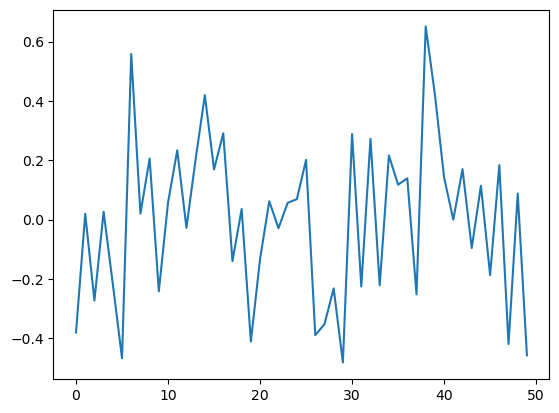

In [45]:
b = model2.B.detach().numpy()
plt.plot(b);

In [98]:
# train a more elaborate model (multi-layered BG that receives input from MC, projects to thalamus)

class bgLearningRNN_v2(nn.Module):
    def __init__(self, nneurons_ctx: int = 200, nneurons_thal: int=50, nneurons_bg: list=[50,20,10],  save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights (from the previously trained model)
        self.J = nn.Parameter(torch.from_numpy(J.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy(W_out.astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy(W_in.astype(np.float32)).to(device))
        self.U    = nn.Parameter(torch.from_numpy((U.T).astype(np.float32)).to(device))
        self.V    = nn.Parameter(torch.from_numpy((V.T).astype(np.float32)).to(self.device))
        self.BG0    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_bg[0], nneurons_ctx)/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.BG1    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_bg[1], nneurons_bg[0])/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.BG2    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_bg[2], nneurons_bg[1])/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.BG3    = nn.Parameter(torch.from_numpy((np.random.randn(nneurons_thal, nneurons_bg[2])/np.sqrt(nneurons_ctx)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.Loss = []
        self.output = None
        self.inputs = None
        self.batch_size = 2
        self.initialState_ctx = torch.from_numpy(initialState_ctx).to(device)
        self.initialState_thal = torch.from_numpy(initialState_thal).to(device)

    def create_targets_and_inputs(self, frequencies=None, amplitudes=None):

        if frequencies is None:
            frequencies = [1, 2]
        if amplitudes is None:
            amplitudes = [1,1]

        # time when input goes high
        start_idx=0

        # index where the output starts
        movement_start_idx=0

        # choose a movement duration for this trial
        move_duration =  Input.shape[0]*self.dt

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # hack to only have 1 condition (trained twice per batch)
        inputs[:,1] = inputs[:,0]

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitudes[ii] * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-5):
        device = self.device
        batch_size = 2
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState_ctx
            rm1 = self.neural_nonlinearity(xm1)

            xthal = self.initialState_thal
            rthal = self.neural_nonlinearity(xthal)

            for idx in np.arange(0,trial_length):

                # update cortex
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) + self.V.T @ rthal +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)

                # update BG
                rbg0 = self.neural_nonlinearity(self.BG0 @ rm1)
                rbg1 = self.neural_nonlinearity(self.BG1 @ rbg0)
                rbg2 = self.neural_nonlinearity(self.BG2 @ rbg1)

                # update thalamus
                xthal = (self.U.T @ rm1) + (self.BG3 @ rbg2)
                rthal = self.neural_nonlinearity(xthal)

                # get network output
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]

        # average loss over time and trials
        loss = ((Targets - position_store)**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_bg(self, trials: int = 100, amplitudes = None,frequencies = None):

        if amplitudes is None:
            amplitudes = [1,1]
        if frequencies is None:
            frequencies = [1,2]

        bg_params = [self.BG0, self.BG1, self.BG2, self.BG3]
        optimizer = torch.optim.Adam(bg_params, lr=1e-3)

        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs(amplitudes=amplitudes,frequencies=frequencies)
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

In [107]:
# fit new model
model3 = bgLearningRNN_v2()
model3.fit_bg(trials = 5000,amplitudes=[1.25,1.25],frequencies=[1.5,1.5]);

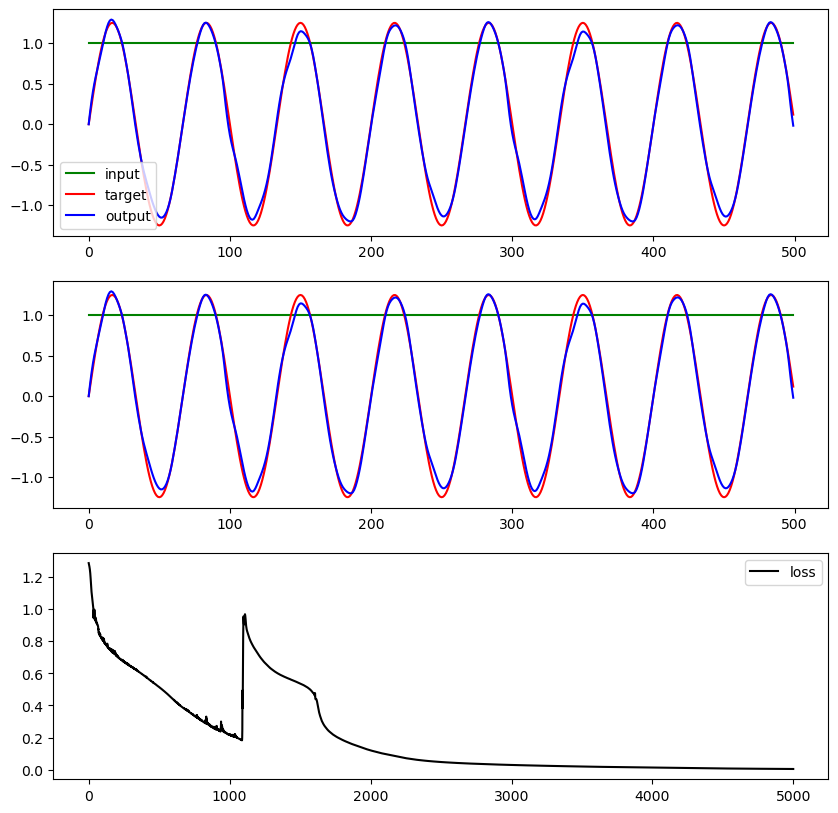

In [108]:
# plot the final output and the loss over training
modelOutput = model3.output.detach().numpy()
target = model3.Targets
input = model3.Inputs
loss = model3.Loss
plt.figure(figsize=(10,10))
for ii in range(2):

    plt.subplot(3,1,ii+1);
    plt.plot(input[:,ii],'g',label='input');
    plt.plot(target[:,ii],'r',label = 'target');
    plt.plot(modelOutput[:,ii],'b',label='output');
    if ii == 0:
        plt.legend();\


plt.subplot(3,1,3);
plt.plot(loss,'k',label='loss');
plt.legend();

In [ ]:
# return the rates (and inputs, targets, and outputs)
# rates are T x N x C
inputs, targets, output, rates = model.returnRates()

# pull out some useful numbers
trialDur, numN, numC = rates.shape

# plot target and output
for ii in range(2):
    plt.subplot(2,1,ii+1)
    plt.plot(targets[:,ii],'r')
    plt.plot(output[:,ii],'b');


In [ ]:
# calculate the alignment between conditions
def calculateAI(X1,X2,numDims):

    # calculate the covariance matrix of X2
    X2_center = X2 - np.mean(X2, axis=0)
    C2 = (X2_center.T @ X2_center) / (X2_center.shape[0]-1)

    # run pca on X1 and X2
    pca1 = PCA(n_components=numDims)
    pca1.fit(X1)

    pca2 = PCA(n_components=numDims)
    pca2.fit(X2)

    # grab the pcs from X1 (spits out a k x N matrix by default)
    W = pca1.components_.T

    # calculate the variance explained by the top 'nDims' PCs of X2
    totVar = sum(pca2.explained_variance_)

    # calculate alignment index
    AI = np.trace((W.T @ C2 @ W)) / totVar

    return AI

In [ ]:
ai = calculateAI(rates[:,:,0],rates[:,:,1],10)
ai_control = calculateAI(rates[:300,:,0],rates[300:,:,0],4)
print('alignment index: ' + str(ai))
print('alignment index within one condition: ' + str(ai_control))

In [ ]:
# run pca on the rates and extract the top K factors

# turn rates into a CT x N matrix
rates_rs = rates.transpose(0,2,1).reshape(-1,numN,order='F')

pca = PCA(n_components=numN)
proj = pca.fit_transform(rates_rs)

# generate a scree plot
varExp = pca.explained_variance_ratio_
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(varExp),'k')
plt.ylabel('fraction of total variance');
plt.xlabel('dimension');
plt.xlim([0,20]);

# print some useful values
print('four dimensions explain ' + str(np.sum(varExp[:4])) + ' percent of total variance');
print('ten dimensions explain ' + str(np.sum(varExp[:10])) + ' percent of total variance');

In [ ]:
proj_rs = proj.reshape(-1,2,200,order='F')

# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,2, figsize = (10,15))

# only plot 1 condition
cond = 0


for ii in range(10):

    for jj in range(2):

        # get the row and column index
        rIdx = np.mod(ii,numRows)
        cIdx = (ii//numRows)

        # plot the target
        ax[rIdx,cIdx].plot(proj_rs[:,jj,ii],linewidth=1.5);




### Train a second model to generate Z

In [ ]:
### Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1


# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 10

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
#W_in = model.Win.detach().numpy()
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

## define our target latents, Z ##
Z_target = proj[:,:numZ]

# reshape to be T x C x K
Z_target_rs = Z_target.reshape(-1,numC,numZ,order='F').transpose(0,2,1)


## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 30

## trial duration ##
trlDur = rates.shape[0]

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ,1))

## initial value of P ##
P = np.eye(numN) / alpha

## scale of the training noise ##
noiseScale = 1e-6


In [ ]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ,numC,numTrials))

for trl in range(numTrials):

    # cycle through conditions
    for cc in range(numC):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through the trial
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (U.T@z) + (INPUT[ii,cc] * W_in)
                            + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the output
            networkOutput[ii,:,cc,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target_rs[ii,:,cc])

            # update the weights
            W = W - ((P @ r)@error)

            # update P
            P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


In [ ]:
# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,2, figsize = (10,15))

# only plot one condition
cond = 0

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs[:,ii,cond],'k',linewidth=3,label='target');

    # plot the first trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')

    # change the y scale
    #ax[rIdx,cIdx].set_ylim([-15,15]);


    if ii==0:
        ax[rIdx,cIdx].legend()


In [ ]:
# plot error (averaged over output dimensions) as a function of training steps
meanError = ((networkOutput - np.tile(Z_target_rs[:,:,:,np.newaxis], (1,1,1,numTrials)))**2).mean(axis=1).squeeze().mean(axis=1).squeeze()

# reshape to be size (T x Trl) x 1
meanError_rs = np.reshape(meanError,(-1,1),order='F')

# plot
plt.plot(meanError_rs[:,0],'k',label='mean error');
plt.legend();
plt.xlabel('time steps');
# plt.ylabel('error');

In [ ]:
# save the FORCE weights
# use the same timestamp as above
data_dict = {'J0': J0, 'U': U,'W': W, 'W_in': W_in,
             'x0': x0, 'r0': r0, 'z0': z0,
             'Z_target': Z_target, 'INPUT': INPUT}
np.save(savePath + ct + '_FORCE_network.npy',data_dict)

In [ ]:
# or load the FORCE weights
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/multiSpeedCycling/'

# file to load
fName = '2023-08-29 13_40_23_FORCE_network.npy'

data = np.load(savePath + fName,allow_pickle=True)
data = data.ravel()[0]

# parse all of our saved variables
J0       = data['J0']
U        = data['U']
W        = data['W']
W_in     = data['W_in']
x0       = data['x0']
r0       = data['r0']
z0       = data['z0']
Z_target = data['Z_target']
INPUT    = data['INPUT']

In [ ]:
# calculate alignment index between conditions
rates,_,out = returnRates(u=U,ipt=inputs,w=W,j0=J0,w_in=W_in)
ai = calculateAI(rates[100:,0,:].squeeze(),rates[100:,1,:].squeeze(),5)
ai_control = calculateAI(rates[:300,0,:].squeeze(),rates[300:,0,:].squeeze(),5)
print('alignment index: ' + str(ai))
print('alignment index within one condition: ' + str(ai_control))

In [ ]:
##  how orthogonal are U and W? ##

# normalize columns of W and (rows of) U to unity
W_norm = W / np.linalg.norm(W,axis=0)
U_norm = (U.T / np.linalg.norm(U.T,axis=0)).T

# calculate product of U and W
plt.figure(figsize=(5,5))
plt.imshow(U_norm@W_norm,cmap='RdBu',vmin=-1,vmax=1);plt.colorbar();
plt.title('U @ W');


### Plug in a B
    - B will allow us to readout the target (for the rate network) from the activity of the units
    - B will be orthogonal-ish to W

In [ ]:
# function for getting the rates from the trained network
def returnRates(u,ipt,w,j0,w_in,b=None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates   = np.zeros((trlDuration, numConds, numUnits))
    allLatents = np.zeros((trlDuration, numConds, numLatents))
    allOutputs = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (ipt[ii,cc] * w_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs

In [ ]:
# variation on the function above.
# keep track of the 'perturbed' input to each neuron (Z * U) and the unperterbed input (Z * dU)
def returnRates_separateU(u,u_pert,ipt,w,j0,w_in,b=None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates     = np.zeros((trlDuration, numConds, numUnits))
    allLatents   = np.zeros((trlDuration, numConds, numLatents))
    allPertInput = np.zeros((trlDuration,numConds,numUnits,numLatents))
    allInput     = np.zeros((trlDuration,numConds,numUnits,numLatents))
    allOutputs   = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (u_pert.T@z) + (ipt[ii,cc] * w_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # save the perturbed input
            allPertInput[ii,cc,:,:] = u_pert.T * z[:,0]

            # save the unperturbed input
            allInput[ii,cc,:,:] = u.T * z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs, allInput, allPertInput

In [ ]:
## use regression to define a B ##

# get rates from the trained FORCE network
rates,latents,_ = returnRates(U,inputs,w=W,j0=J0,w_in=W_in)

# reshape to be CT x N
rates_rs = rates.reshape(-1,numN,order='F');

# reshape the targets from our rate network
targets_rs = targets.reshape(-1,1,order='F')

# define a regularization term
ridgeLambda = 1e-4

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W.T)
rates_null = rates_rs@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
B = W_null@b_null

# plot target and target_hat
yHat = rates_rs@B
plt.figure(figsize=(20,10))
plt.subplot(3,1,1);
plt.plot(targets_rs,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(3,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();

# calculate correlation between B and each column of W
plt.subplot(3,1,3);
bCorr = np.zeros(numZ) + np.nan
for ii in range(numZ):
    bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
plt.ylim([-0.1,0.1]);
plt.legend();


### Does learning in one context automatically generalize to the other?
    - In a different network, I can learn a dU that changes the frequency of the output.
    - If I try to use a context signal to learn two different frequencies (i.e., skills), the learning generalizes between the skills, such that I can't get the network to cycle faster in one context and slower in another.
    - As a sanity check, I want to verify that I can alter the frequency of one context in a network that has already been trained to cycle at two different frequencies.
    - If this experiment doesn't work, then we need to think more carefully about what a translation in state space actually does, mechanistically.

In [ ]:
# function for returning peak frequency of a 1d Trace
# FFT doesn't give me the resolution I want, so just make a bunch of waves at different frequencies and ask which one matches our signal best

def returnPeakFreq(signal, minFreq = 0.8, maxFreq = 1.2, numFreqs = 100):

    # length of our signal
    L = signal.shape[0]

    # time vector
    t = np.arange(L)

    # vector of frequencies to test
    freqs = np.linspace(minFreq,maxFreq,numFreqs)

    # vector to hold the dot product of our signal and the waves we make
    mags = np.zeros(numFreqs) + np.nan

    # cycle through all of our frequencies
    for idx,f in enumerate(freqs):

        # make our templates
        testSin = np.sin(f*0.01 * 2 * np.pi * t)
        testCos = np.cos(f*0.01 * 2 * np.pi * t)

        mags[idx] = np.dot(signal,testSin) + np.dot(signal,testCos)

    # return the frequency that matches best
    return freqs[np.argmax(mags)]

# function for returning the MSE between two traces, after one has been stretched to match the other.
def calculateAdjustedMSE(signal1, signal2, freq1, freq2):

    # duration of original signal
    oSignalDur = signal1.size

    # figure out which signal needs to be stretched
    if freq1 < freq2:
        slowSignal = signal1
        fastSignal = signal2
        slowFreq = freq1
        fastFreq = freq2
        stretchFlag = True
    elif freq2 < freq1:
        slowSignal = signal2
        fastSignal = signal1
        slowFreq = freq2
        fastFreq = freq1
        stretchFlag = True
    else:
        # if both signals have the same dominant frequency, no need to do any stretching
        slowSignal = signal1
        fastSignal = signal2
        stretchFlag = False

    if stretchFlag:

        # calculate the ratio of the fast signal to the slow signal
        freqRatio = fastFreq/slowFreq

        # generate a stretched time base for the faster signal
        fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio

        # interpolate the faster signal to get a signal the same length as the slow signal
        fastSignal = np.interp(np.arange(0,oSignalDur),fastTimes_stretched,fastSignal)

    # now calculate the MSE
    return ((slowSignal - fastSignal)**2).mean()

In [ ]:
# function that learns a dU to change the cycling frequency in one context

def runSingleDirectionLearning(IN,w,u,j0,w_in,b,numTrials=10,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.05,targetFreq = 1.8):


    # initialize the U (keep it separate from our original U
    U_learn = np.copy(u)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,originalOutput = returnRates(u = U_learn,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 1.9, maxFreq = 2.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # keep track of the amplitude
    allAmp = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # allowed amplitude range (after perturbation)
    maxAmp = oAmp + (oAmp * ampChangeThreshold)
    minAmp = oAmp - (oAmp * ampChangeThreshold)

    # amplitude of current best output
    cAmp = oAmp

    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # generate our perturbed U
        U_pert = U_learn + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # generate a perturbed output
        _,_,newOutput = returnRates(u = U_pert,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.5, maxFreq = currentFreq+0.5)

        # calculate new error
        nError = (nFreq - targetFreq)**2

        # check that our amplitude hasn't changed too much
        pertAmp = np.max(newOutput[-200:,0])

        # incorporate the change if things got better
        if (nError < error) & (minAmp <= pertAmp <= maxAmp):
            U_learn = np.copy(U_pert)
            error = nError
            currentFreq = np.copy(nFreq)
            cAmp = pertAmp

        # save our error
        allError[ii] = error
        allAmp[ii] = cAmp

    # return error and our learned U
    return U_learn,allError,allAmp

In [ ]:
# function that learns a dU to change the cycling frequency in one context
# learns with an eligibility trace

def runSingleDirectionLearning_elTrace(IN,w,u,j0,w_in,b,numTrials=10,alpha=0.01,pertMag=1e-5,targetFreq = 1.8):

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(u)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,originalOutput = returnRates(u = U_learn,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 1.9, maxFreq = 2.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # calculate current error
    error = returnError(tFreq=targetFreq,freq=currentFreq,tAmp=oAmp,amp=oAmp)

    # keep track of dU
    dU_all = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # keep track of all of the frequencies
    freqAll = np.zeros(numTrials)

    # keep track of all of the eligibility traces
    elTrace_all = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))


    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        uPert = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        uPert = (uPert.T/ np.linalg.norm(uPert,axis=1)).T
        uPert = uPert * pertMag

        # generate a perturbed output
        rates,latents,newOutput,noPertInput,pertInput = returnRates_separateU(u=U_learn,u_pert=uPert,ipt=IN,w=W,j0=J0,w_in=W_in,b=B)

        # calculate the eligibility trace for each synapse
        elTrace = returnElTrace(pertInput[100:,:,:],noPertInput[100:,:,:])

        # save the eligibility trace
        elTrace_all[:,:,ii] = elTrace[0,:,:].T

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.5, maxFreq = currentFreq+0.5,numFreqs = 500)
        freqAll[ii] = nFreq

        # calculate the new amplitude
        pertAmp = np.max(np.abs(newOutput[-200:,0]))

        # calculate new error
        nError = returnError(tFreq=targetFreq,freq=nFreq,tAmp=oAmp,amp=pertAmp)

        # only update if things got better
        if (error - nError) > 0:

            # calculate update
            # dU = alpha * (error - nError) * elTrace
            # dU = dU[0,:,:].T * uPert
            dU = uPert * elTrace[0,:,:].T

            # update U_learn
            U_learn += dU

            # re-normalize
            U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
            U_learn = U_learn * U_norm[:,np.newaxis]

            # update error
            error = np.copy(nError)
        else:
            dU = np.zeros_like(U)

        # save dU
        dU_all[:,:,ii] = dU

        # save our error
        allError[ii] = error

        # update current frequency
        currentFreq = np.copy(nFreq)

    # return error and our learned U
    return U_learn,allError,dU_all, elTrace_all,freqAll

# return current error (function of output amplitude and output frequency)
def returnError(tFreq,freq, tAmp, amp, freqWeight=1,ampWeight=0.5):

    return freqWeight * ((tFreq - freq)**2) + ampWeight * ((tAmp - amp)**2)

# return the eligibility trace for each synapse
# for now, this is just a threshold
def returnElTrace(pIn,noPIn,tHold=1e-2):


    # each synapse has an eligibility trace
    # the eligibility trace for a given synapse is the dot product of the perturbed (Z * dU) and unperturbed (Z * U) input

    # calculate the product, sum,  and push through supralinear function

    #synProd = (np.sum(pIn * upIn,axis=0))**3

    # mean center the inputs
    noPIn = noPIn - np.mean(noPIn,axis=0)
    pIn = pIn - np.mean(pIn,axis=0)

    synProd = np.sum(noPIn * pIn,axis=0)**3

    # threshold
    thresholdProd = (np.abs(synProd) > tHold).astype('int')

    #  take sum over time, return output
    return thresholdProd

# function for finding scaling of vector A such that the norm of the sum of A and B is equal to C
def find_scaling_factor(A, B, C):
    # Calculate the norms of A and B
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)

    # Calculate the dot product of A and B
    dot_AB = np.dot(A, B)

    # Coefficients for the quadratic equation
    a = norm_A ** 2
    b = 2 * dot_AB
    c = norm_B ** 2 - C ** 2

    # Calculate the discriminant
    discriminant = b ** 2 - 4 * a * c

    # Check if discriminant is negative
    if discriminant < 0:
        return "No real solutions for k"

    # Calculate the two possible values for k
    k1 = (-b + np.sqrt(discriminant)) / (2 * a)
    k2 = (-b - np.sqrt(discriminant)) / (2 * a)

    # only keep the positive value
    k = np.array([k1,k2])
    k = k[k>0]

    return k

In [ ]:
# run the experiment (with the eligibility trace)

# here, we're going to decrease the frequency of the output in context 2 from 2 to 1.8

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,dU_all,elTrace_all,freqAll = runSingleDirectionLearning_elTrace(trainingInput,w=W,u=U,j0=J0,w_in=W_in,b=B,numTrials=1000,alpha=1,pertMag=1e-2,targetFreq = 1.5)

# plot results
_,oLatentsTrain,out0_training = returnRates(U,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,oLatentsTest,out0_testing = returnRates(U,testingInput,w=W,j0=J0,w_in=W_in,b=B)
_,latentsTrain,outTraining = returnRates(U_learn,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,latentsTest,outTesting = returnRates(U_learn,testingInput,w=W,j0=J0,w_in=W_in,b=B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.4, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.5, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');

In [ ]:
x = np.linalg.norm(dU_all,axis=1)
plt.plot(x[:5,:].T);

In [ ]:
idx = 4
plt.plot(latentsTrain[:,0,idx],'b');
plt.plot(latentsTest[:,0,idx],'r');
plt.plot(oLatentsTrain[:,0,idx],'b--');
plt.plot(oLatentsTest[:,0,idx],'r--');

In [ ]:
y = np.linalg.norm(elTrace_all,axis=1)
plt.plot(y[0:4,:].T);

In [ ]:
plt.plot(x[0,:]);

In [ ]:
U_learn = np.copy(U)
U_norm = np.linalg.norm(U_learn,axis=1)
IN_train = np.zeros((1000,1)) + 2
IN_test = np.zeros((1000,1)) + 1
pertMag = 5e-3

_,_,output0_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
_,_,output0_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

freq0_train = returnPeakFreq(output0_train,minFreq = 1.7, maxFreq = 2.2)
freq0_test = returnPeakFreq(output0_test,minFreq = 0.7, maxFreq = 1.2)

freq1_train = np.zeros(1000)
freq1_test = np.zeros(1000)

for ii in range(1000):

    U_learn = np.copy(U)

    # generate a perturbation matrix for U.
    U_pert = 2 * np.random.random_sample(size=U.shape) -1

    # scale each row of U to have a magnitude of 'pertMag'
    U_pert = (U_pert.T/ np.linalg.norm(U_pert,axis=1)).T
    U_pert = U_pert * pertMag

    # add to U_learn
    U_learn += U_pert

    # normalize
    U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
    U_learn = U_learn * U_norm[:,np.newaxis]

    _,_,output1_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
    _,_,output1_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

    freq1_train[ii] = returnPeakFreq(output0_train,minFreq = 1.5, maxFreq = 2.5,numFreqs = 500)
    freq1_test[ii] = returnPeakFreq(output0_test,minFreq = 0.7, maxFreq = 1.2,numFreqs = 500)





# rescale U_learn
U_learn = (U_learn.T / np.linalg.norm(U_learn,axis=1)).T
U_learn = U_learn * U_norm[:,np.newaxis]



# generate a perturbed output
_,_,output1_train = returnRates(u=U_learn,ipt=IN_train,w=W,j0=J0,w_in=W_in,b=B)
_,_,output1_test = returnRates(u=U_learn,ipt=IN_test,w=W,j0=J0,w_in=W_in,b=B)

#
# U_new = U_learn + U_pert
#
# U_new = (U_new.T / np.linalg.norm(U_new,axis=1)).T
# U_new = U_new * U_norm[:,np.newaxis]
#
# # generate a perturbed output
# _,_,normOutput = returnRates(u = U_learn + U_pert,ipt = IN,b=B,w=W,j0=J0,w_in=W_in)
#
# # calculate the eligibility trace for each synapse
# elTrace = returnElTrace(rates,pertInput)
#
# # calculate the new frequency
# nFreq = returnPeakFreq(newOutput[:,0],minFreq = 1.7, maxFreq = 2.1)
#
# # calculate the new amplitude
# pertAmp = np.max(newOutput[-200:,0])
#
# # calculate new error
# nError = returnError(tFreq=1.8,freq=nFreq,tAmp=1,amp=pertAmp)
#
# # calculate update
# dU = alpha * (1 - nError) * elTrace
#
# print(nFreq)
# plt.plot(newOutput[:,0]);
# plt.plot(normOutput[:,0]);
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.plot(output0_train[:,0],'b',label='train pre');
plt.plot(output1_train[:,0],'r',label='train post');
plt.legend();

plt.subplot(1,2,2);
plt.plot(output0_test[:,0],'b',label='test pre');
plt.plot(output1_test[:,0],'r',label='test post');
plt.legend();

In [ ]:
W_pert / np.linalg.norm(W_pert,axis=0)

In [ ]:
W_learn = np.copy(W)
W_norm = np.linalg.norm(W_learn,axis=0)
IN_train = np.zeros((1000,1)) + 2
IN_test = np.zeros((1000,1)) + 1
pertMag = 0.15

_,_,output0_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
_,_,output0_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)

freq0_train = returnPeakFreq(output0_train[:,0],minFreq = 1.7, maxFreq = 2.2)
freq0_test = returnPeakFreq(output0_test[:,0],minFreq = 0.7, maxFreq = 1.2)

freq1_train = np.zeros(1000)
freq1_test = np.zeros(1000)

for ii in range(1000):

    W_learn = np.copy(W)

    # generate a perturbation matrix for U.
    W_pert = 2 * np.random.random_sample(size=W.shape) -1

    # scale each row of U to have a magnitude of 'pertMag'
    W_pert = (W_pert/ np.linalg.norm(W_pert,axis=0))
    W_pert = W_pert * pertMag

    # add to W_learn
    W_learn += W_pert

    # normalize
    W_learn = (W_learn / np.linalg.norm(W_learn,axis=0))
    W_learn = W_learn * W_norm[np.newaxis,:]

    _,_,output1_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
    _,_,output1_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)

    freq1_train[ii] = returnPeakFreq(output1_train[:,0],minFreq = 1.5, maxFreq = 2.5,numFreqs = 500)
    freq1_test[ii] = returnPeakFreq(output1_test[:,0],minFreq = 0.7, maxFreq = 1.2,numFreqs = 500)

In [ ]:
dFreq_train = freq0_train - freq1_train
dFreq_test  = freq0_test - freq1_test

plt.plot(dFreq_train,dFreq_test,'bo');
plt.xlim([-0.05,0.05]);
plt.ylim([-0.05,0.05]);

In [ ]:
dFreq_train = freq0_train - freq1_train
dFreq_test  = freq0_test - freq1_test

plt.plot(dFreq_train,dFreq_test,'bo');
plt.xlim([-0.05,0.05]);
plt.ylim([-0.05,0.05]);

In [ ]:
W_norm

In [ ]:
W_learn = np.copy(W)
W_norm = np.linalg.norm(W_learn,axis=0)
pertMag = 0.5
W_learn = np.copy(W)

# generate a perturbation matrix for U.
W_pert = 2 * np.random.random_sample(size=W.shape) -1

# scale each row of U to have a magnitude of 'pertMag'
W_pert = (W_pert/ np.linalg.norm(W_pert,axis=0))
W_pert = W_pert * pertMag

# add to W_learn
W_learn += W_pert

# normalize
W_learn = (W_learn / np.linalg.norm(W_learn,axis=0))
W_learn = W_learn * W_norm[np.newaxis,:]

_,_,output1_train = returnRates(u=U,ipt=IN_train,w=W_learn,j0=J0,w_in=W_in,b=B)
_,_,output1_test = returnRates(u=U,ipt=IN_test,w=W_learn,j0=J0,w_in=W_in,b=B)


plt.figure(figsize = (10,5))
plt.plot(output0_train,'b');
plt.plot(output0_test,'r');
plt.plot(output1_train,'b--');
plt.plot(output1_test,'r--');

In [ ]:
np.linalg.norm(elTrace**3,axis=0)


In [ ]:
np.linalg.norm(elTrace**3,axis=0)

In [ ]:
np.dot(l[:,0,5,0],r[:,0,0,10])

In [ ]:
plt.plot(l[:,0,5,0])
plt.plot(r[:,0,0,10])

In [ ]:
# run the experiment (no eligibility trace)

# here, we're going to decrease the frequency of the output in context 2 from 2 to 1.8

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(trainingInput,w=W,u=U,j0=J0,w_in=W_in,b=B,numTrials=400,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.01,targetFreq = 1.8)

# plot results
_,_,out0_training = returnRates(U,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,out0_testing = returnRates(U,testingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,outTraining = returnRates(U_learn,trainingInput,w=W,j0=J0,w_in=W_in,b=B)
_,_,outTesting = returnRates(U_learn,testingInput,w=W,j0=J0,w_in=W_in,b=B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');



### When using a static context signal, learning in one context generalizes to the other.
    - This shouldn't happen if the 2 contexts also occur in different sets of dimensions.
    - To probe one extreme, I'll use FORCE to train a Brian network with two sets of W's: one for context 1 and one for context 2.


In [ ]:
###  Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1


# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 10

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ*2,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
#W_in = model.Win.detach().numpy()
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

## define our target latents, Z ##
Z_target = proj[:,:numZ]

# reshape to be T x C x K
Z_target_rs = Z_target.reshape(-1,numC,numZ,order='F').transpose(0,2,1)

# copy the columns of Z_target_rs
Z_target_rs_double = np.tile(Z_target_rs,(1,2,1))

# for context one, the second K dimensions of the target are just zero
Z_target_rs_double[:,numZ:,0] = 0

# for context two, the first K dimensions are set to 0
Z_target_rs_double[:,:numZ,1] = 0



## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 30

## trial duration ##
trlDur = rates.shape[0]

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ*2))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ*2,1))

## initial value of P ##
P = np.eye(numN) / alpha

## scale of the training noise ##
noiseScale = 1e-6


In [ ]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ*2,numC,numTrials))

for trl in range(numTrials):

    # cycle through conditions
    for cc in range(numC):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through the trial
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (U.T@z) + (INPUT[ii,cc] * W_in)
                            + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the output
            networkOutput[ii,:,cc,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target_rs_double[ii,:,cc])

            # update the weights
            W = W - ((P @ r)@error)

            # update P
            P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


In [ ]:
# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,4, figsize = (10,15))

# only plot 1 condition
cond = 0

for ii in range(numZ*2):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs_double[:,ii,cond],'k',linewidth=3,label='target');

    # plot the first trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);


    if ii==0:
        ax[rIdx,cIdx].legend()


In [ ]:
# save the second batch of FORCE weights

# use the same timestamp as above
data_dict = {'J0': J0, 'U': U,'W': W, 'W_in': W_in,
             'x0': x0, 'r0': r0, 'z0': z0,
             'Z_target': Z_target, 'INPUT': INPUT}
np.save(savePath + ct + '_FORCE_network_twoSpaces.npy',data_dict)

In [ ]:
# calculate alignment index between conditions
rates,_,_ = returnRates(U,inputs)
ai = calculateAI(rates[:,0,:].squeeze(),rates[:,1,:].squeeze(),10)
ai_control = calculateAI(rates[:300,0,:].squeeze(),rates[300:,0,:].squeeze(),10)
print('alignment index: ' + str(ai))
print('alignment index within one condition: ' + str(ai_control))

In [ ]:
## use regression to define a B ##

# get rates from the trained FORCE network
rates,latents,_ = returnRates(U,inputs)

# reshape to be CT x N
rates_rs = rates.reshape(-1,numN,order='F');

# reshape the targets from our rate network
targets_rs = targets.reshape(-1,1,order='F')

# define a regularization term
ridgeLambda = 1e-4

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W.T)
rates_null = rates_rs@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
B = W_null@b_null

# plot target and target_hat
yHat = rates_rs@B
plt.figure(figsize=(20,10))
plt.subplot(3,1,1);
plt.plot(targets_rs,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(3,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();

# calculate correlation between B and each column of W
plt.subplot(3,1,3);
bCorr = np.zeros(numZ) + np.nan
for ii in range(numZ):
    bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
plt.ylim([-0.1,0.1]);
plt.legend();

In [ ]:
# run the same learning experiment from above (decrease the frequency of the output in context 2 from 2 to 1.8; output in context 1 should not change).

# define an input
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(trainingInput,numTrials=400,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.01,targetFreq = 1.8)

# plot results
_,_,out0_training = returnRates(U,trainingInput,B)
_,_,out0_testing = returnRates(U,testingInput,B)
_,_,outTraining = returnRates(U_learn,trainingInput,B)
_,_,outTesting = returnRates(U_learn,testingInput,B)

# calculate final speeds
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');
plt.subplots_adjust(top=1.2)

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');
plt.subplots_adjust(top=1.2)

# ### Learn two different perturbations to U: one that increases the amplitude of the output and one that decreases the amplitude
    - both will be drawn from B

In [ ]:
# Perturb U with some fraction of B. Absorb changes that reduce error.

def runPertExperiment(out_o,target_2,IN,numTrials=100,alpha=1,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    bestError = np.zeros(numTrials)
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=pertMag,size=(1,numZ))

        # generate our scaled B vectors
        bScaled = B @ pctB

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # update U_learn if things got better
        if newE < current_e:

            # calculate the percent change in error
            dE = (current_e - newE)/current_e

            # display the change in error
            print(str(dE*100) + ' percent change in error');

            # calculate step size
            step = alpha

            # take a step
            U_learn += (bScaled.T * step)

            # update our current error
            current_e = newE

        # save error
        bestError[ii] = current_e
        trialError[ii]  = newE

    # return error and our learned U
    return U_learn,bestError, trialError


In [ ]:
# rather than choosing perturbations randomly, estimate the gradient by perturbing in a random direction, then taking a step down the gradient
# because we're taking small steps, we should be able to keep an running estimate of the gradient, rather than estimating it from a single perturbation

def runPertExperiment_estGrad(out_o,target_2,IN,numTrials=50,alpha=0.9,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # save all of the gradients
    allGradEst = np.zeros((numZ,numTrials))

    # save all of the delta errors
    dE_all = np.zeros(numTrials)

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=1,size=numZ)

        # normalize pctB to have a norm of 'pertMag'
        pctB_norm = (pctB/np.linalg.norm(pctB))* pertMag

        # make sure the vector is the right size
        pctB_norm = pctB_norm[np.newaxis,:]

        # generate our scaled B vectors
        bScaled = B @ pctB_norm

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # calculate change in error
        dE = newE - current_e

        # save change in error
        dE_all[ii] = dE

        # estimate the gradient
        gradEst = dE / pctB_norm

        # save estimate
        allGradEst[:,ii] = gradEst

        # normalize the gradient
        gradEst_norm = (gradEst / np.linalg.norm(gradEst,axis=1))*pertMag

        # take a step in that direction
        step = gradEst_norm * alpha

        # save the perturbation
        totPert += step[0,:]

        # generate the B perturbation
        bStep = B @ step

        # update U
        U_learn -= bStep.T

        # update and save error
        _,_,out = returnRates(U_learn,IN,B)

        # calculate new error
        current_e = ((out[:,0] - target2)**2).mean()
        trialError[ii]  = np.copy(current_e)

    # return error and our learned U
    return U_learn, trialError, allGradEst, totPert, dE_all

In [ ]:

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)


In [ ]:
# test the gradient estimation method

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up_estGrad, trialError_up_estGrad, gradEst_estGrad,totPert,dE_all = runPertExperiment_estGrad(out_original,target2,IN,numTrials=500)


# plot results

# regenerate the output with the current U
_,_,out_final_estGrad = returnRates(U_l_up_estGrad,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(trialError_up_estGrad,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_estGrad[:,0],'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# find perturbation to increase amplitude of output

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up, bestError_up, trialError_up = runPertExperiment(out_original,target2,IN,alpha=1,numTrials=2000,pertMag=1e-7)

# plot results

# regenerate the output with the current U
_,_,out_final_up = returnRates(U_l_up,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_up,'r',linewidth=2,label='best error')
plt.plot(trialError_up,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_up,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# find perturbation to decrease amplitude of output

# define our new target
amp2 = 0.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_down, bestError_down, trialError_down = runPertExperiment(out_original,target2,IN,numTrials=1500,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_down = returnRates(U_l_down,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_down,'r',linewidth=2,label='best error')
plt.plot(trialError_down,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_down,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


In [ ]:
# see if I can get something a little wonkier

target2 = np.copy(1*targets[:,0] + 1*targets[:,1])

# normalize to a max of 1
target2 = target2 / np.max(target2)

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_wonky, bestError_wonky, trialError_wonky = runPertExperiment(out_original,target2,IN,numTrials=6000,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_wonky = returnRates(U_l_wonky,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_wonky,'r',linewidth=2,label='best error')
plt.plot(trialError_wonky,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_wonky,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();

In [ ]:
# generate latents for each of these learned U perturbations

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedLatents = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    _,tempLats,_ = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedLatents.append(tempLats)

# cycle through all of the latents and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [8,4,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedLatents[jj][:,0,ii],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()

In [ ]:
# plot a few example units

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedRates = []
perturbedOutput = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    tempRates,_,output = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedRates.append(tempRates)
    perturbedOutput.append(output)

#cycle through the first 10 units and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# choose 10 random neurons to plot
randIdx = np.random.choice(numN,size=numZ,replace=False)

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [1,1,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedRates[jj][:,0,randIdx[ii]],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-1.5,1.5]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()